# Stance Detection for the Fake News Challenge

## Identifying Textual Relationships with Deep Neural Nets

### Check the problem context [here](https://drive.google.com/open?id=1KfWaZyQdGBw8AUTacJ2yY86Yxgw2Xwq0).

### Download files required for the project from [here](https://drive.google.com/open?id=10yf39ifEwVihw4xeJJR60oeFBY30Y5J8).

## Step1: Load the given dataset  

1. Mount the google drive

2. Import Glove embeddings

3. Import the test and train datasets

### Mount the google drive to access required project files

Run the below commands

In [0]:
from google.colab import drive

In [2]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


#### Path for Project files on google drive

**Note:** You need to change this path according where you have kept the files in google drive. 

In [0]:
project_path = "/content/drive/My Drive/Fake News Challenge/"

### Loading the Glove Embeddings

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'glove.6B.zip', 'r') as z:
  z.extractall()

# Load the dataset [5 Marks]

1. Using [read_csv()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) in pandas load the given train datasets files **`train_bodies.csv`** and **`train_stances.csv`**

2. Using [merge](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) command in pandas merge the two datasets based on the Body ID. 

Note: Save the final merged dataset in a dataframe with name **`dataset`**.

In [0]:
import pandas as pd
import numpy as np

In [0]:
#Reading the datasets
train_bodies = pd.read_csv(project_path+ "train_bodies.csv")
train_stances = pd.read_csv(project_path + "train_stances.csv")

In [7]:
#Checking the top 5 train_bodies
train_bodies.head()

,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [8]:
#checking the Top 5 Stances
train_stances.head()

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


In [0]:
#Merging the train_bodies and train_stances
dataset = pd.merge(train_bodies[['Body ID','articleBody']],train_stances[['Headline','Body ID','Stance']])


<h2> Check1:</h2>
  
<h3> You should see the below output if you run `dataset.head()` command as given below </h3>

In [10]:
dataset.head()

,Body ID,articleBody,Headline,Stance
0,0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",unrelated
1,0,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...,unrelated
2,0,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,unrelated
3,0,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated
4,0,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,unrelated


## Step2: Data Pre-processing and setting some hyper parameters needed for model


#### Run the code given below to set the required parameters.

1. `MAX_SENTS` = Maximum no.of sentences to consider in an article.

2. `MAX_SENT_LENGTH` = Maximum no.of words to consider in a sentence.

3. `MAX_NB_WORDS` = Maximum no.of words in the total vocabualry.

4. `MAX_SENTS_HEADING` = Maximum no.of sentences to consider in a heading of an article.

In [0]:
MAX_NB_WORDS = 20000
MAX_SENTS = 20
MAX_SENTS_HEADING = 1
MAX_SENT_LENGTH = 20
VALIDATION_SPLIT = 0.2

### Download the `Punkt` from nltk using the commands given below. This is for sentence tokenization.

For more info on how to use it, read [this](https://stackoverflow.com/questions/35275001/use-of-punktsentencetokenizer-in-nltk).



In [12]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Tokenizing the text and loading the pre-trained Glove word embeddings for each token  [5 marks] 


Keras provides [Tokenizer API](https://keras.io/preprocessing/text/) for preparing text. Read it before going any further.

#### Import the Tokenizer from keras preprocessing text

In [13]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


#### Initialize the Tokenizer class with maximum vocabulary count as `MAX_NB_WORDS` initialized at the start of step2. 

In [0]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)

#### Now, using fit_on_texts() from Tokenizer class, lets encode the data 

Note: We need to fit articleBody and Headline also to cover all the words.

In [0]:
tokenizer.fit_on_texts(dataset['articleBody'])
tokenizer.fit_on_texts(dataset['Headline'])

#### fit_on_texts() gives the following attributes in the output as given [here](https://faroit.github.io/keras-docs/1.2.2/preprocessing/text/).

* **word_counts:** dictionary mapping words (str) to the number of times they appeared on during fit. Only set after fit_on_texts was called.

* **word_docs:** dictionary mapping words (str) to the number of documents/texts they appeared on during fit. Only set after fit_on_texts was called.

* **word_index:** dictionary mapping words (str) to their rank/index (int). Only set after fit_on_texts was called.

* **document_count:** int. Number of documents (texts/sequences) the tokenizer was trained on. Only set after fit_on_texts or fit_on_sequences was called.



### Now, tokenize the sentences using nltk sent_tokenize() and encode the senteces with the ids we got form the above `t.word_index`

Initialise 2 lists with names `texts` and `articles`.

```
texts = [] to store text of article as it is.

articles = [] split the above text into a list of sentences.
```

In [0]:
from nltk import tokenize

In [17]:
#Vocabulary size 
vocab_size = len(tokenizer.word_index) + 1
print("Voabulary Size: ",vocab_size )

Voabulary Size:  27874


In [0]:
#To store the text of article as it is
texts = []
#split the above text into a list of sentences
articles = []

In [0]:
#Splitting articleBody into sentences
for i in range(dataset["articleBody"].shape[0]):
  t = dataset["articleBody"][i]
  texts.append(t)
  s = tokenize.sent_tokenize(t)
  articles.append(s)

## Check 2:

first element of texts and articles should be as given below. 

In [20]:
texts[0]

'A small meteorite crashed into a wooded area in Nicaragua\'s capital of Managua overnight, the government said Sunday. Residents reported hearing a mysterious boom that left a 16-foot deep crater near the city\'s airport, the Associated Press reports. \n\nGovernment spokeswoman Rosario Murillo said a committee formed by the government to study the event determined it was a "relatively small" meteorite that "appears to have come off an asteroid that was passing close to Earth." House-sized asteroid 2014 RC, which measured 60 feet in diameter, skimmed the Earth this weekend, ABC News reports. \nMurillo said Nicaragua will ask international experts to help local scientists in understanding what happened.\n\nThe crater left by the meteorite had a radius of 39 feet and a depth of 16 feet,  said Humberto Saballos, a volcanologist with the Nicaraguan Institute of Territorial Studies who was on the committee. He said it is still not clear if the meteorite disintegrated or was buried.\n\nHumbe

In [21]:
articles[0]

["A small meteorite crashed into a wooded area in Nicaragua's capital of Managua overnight, the government said Sunday.",
 "Residents reported hearing a mysterious boom that left a 16-foot deep crater near the city's airport, the Associated Press reports.",
 'Government spokeswoman Rosario Murillo said a committee formed by the government to study the event determined it was a "relatively small" meteorite that "appears to have come off an asteroid that was passing close to Earth."',
 'House-sized asteroid 2014 RC, which measured 60 feet in diameter, skimmed the Earth this weekend, ABC News reports.',
 'Murillo said Nicaragua will ask international experts to help local scientists in understanding what happened.',
 'The crater left by the meteorite had a radius of 39 feet and a depth of 16 feet,  said Humberto Saballos, a volcanologist with the Nicaraguan Institute of Territorial Studies who was on the committee.',
 'He said it is still not clear if the meteorite disintegrated or was bu

# Now iterate through each article and each sentence to encode the words into ids using t.word_index  [5 marks] 

Here, to get words from sentence you can use `text_to_word_sequence` from keras preprocessing text.

1. Import text_to_word_sequence

2. Initialize a variable of shape (no.of articles, MAX_SENTS, MAX_SENT_LENGTH) with name `data` with zeros first (you can use numpy [np.zeros](https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros.html) to initialize with all zeros)and then update it while iterating through the words and sentences in each article.

In [0]:
#Importing libraries
from keras.preprocessing.text import text_to_word_sequence

In [0]:
#Encoding article
data = np.zeros((len(texts), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')
#Word index encoding
for i, s in enumerate(articles):
    for j, sentence in enumerate(s):
        if j < MAX_SENTS:
            Tokens = text_to_word_sequence(sentence)
            k = 0
            for _, token in enumerate(Tokens):
                try:
                    if k < MAX_SENT_LENGTH and tokenizer.word_index[token] < MAX_NB_WORDS:
                      data[i, j, k] = tokenizer.word_index[token]
                      k = k + 1
                except:
                      #print(token)
                        pass

### Check 3:

Accessing first element in data should give something like given below.

In [24]:
data[0, :, :]

array([[    3,   481,   427,  7211,    81,     3,  3733,   331,     5,
         3891,   350,     4,  1431,  2958,     1,    89,    12,   464,
            0,     0],
       [  758,    95,  1047,     3,  2679,  1752,     7,   189,     3,
         1217,  1075,  2030,   700,   159,     1,  3032,   448,     1,
          555,   235],
       [   89,  1067,  4115,  2349,    12,     3,  1092,  3306,    19,
            1,    89,     2,  1793,     1,   521,  2009,    15,     9,
            3,  3111],
       [  181,  3640,   972,   200,  2556,    44,  6775,  1722,  1252,
            5, 13317, 17936,     1,   778,    31,   740,  3990,    67,
           85,     0],
       [ 2349,    12,  1557,    38,  1094,   351,   775,     2,   367,
          260,  1770,     5,  4450,    70,   494,     0,     0,     0,
            0,     0],
       [    1,   700,   189,    19,     1,   427,    32,     3,  7417,
            4,  2159,  1252,     6,     3,  5270,     4,  1217,  1252,
           12,  3363],
       [  

# Repeat the same process for the `Headings` as well. Use variables with names `texts_heading` and `articles_heading` accordingly. [5 marks] 

In [0]:
#To store text heading of article as it is
texts_heading = []
#split the above text heading into a list of sentences
articles_heading = []

In [0]:
#Splitting Headine into sentences
for i in range(dataset["Headline"].shape[0]):
  t = dataset["Headline"][i]
  texts_heading.append(t)
  s = tokenize.sent_tokenize(t)
  articles_heading.append(s)

In [27]:
texts_heading[0]

'Soldier shot, Parliament locked down after gunfire erupts at war memorial'

In [28]:
articles_heading[0]

['Soldier shot, Parliament locked down after gunfire erupts at war memorial']

In [0]:
#Encoding article
data_heading = np.zeros((len(texts), MAX_SENTS_HEADING, MAX_SENT_LENGTH), dtype='int32')
#Word index encoding
for i, s in enumerate(articles_heading):
    for j, sentence in enumerate(s):
        if j < MAX_SENTS_HEADING:
            Tokens = text_to_word_sequence(sentence)
            k = 0
            for _, token in enumerate(Tokens):
                try:
                    if k < MAX_SENT_LENGTH and tokenizer.word_index[token] < MAX_NB_WORDS:
                      data_heading[i, j, k] = tokenizer.word_index[token]
                      k = k + 1
                except:
                      #print(token)
                        pass

In [30]:
data_heading[0, :, :]

array([[  718,   206,   343,  7134,   193,    34,  1338, 11554,    21,
          233,   686,     0,     0,     0,     0,     0,     0,     0,
            0,     0]], dtype=int32)

### Now the features are ready, lets make the labels ready for the model to process.

### Convert labels into one-hot vectors

You can use [get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) in pandas to create one-hot vectors.

In [0]:
#Converting labels into one-hot vectors
labels = dataset['Stance']
labels = pd.get_dummies(labels, sparse=True)
labels = np.asarray(labels)

In [32]:
labels

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]], dtype=uint8)

### Check 4:

The shape of data and labels shoould match the given below numbers.

In [33]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (49972, 20, 20)
Shape of label tensor: (49972, 4)


In [34]:
print('Shape of Heading tensor:', data_heading.shape)

Shape of Heading tensor: (49972, 1, 20)


### Shuffle the data

In [0]:
## get numbers upto no.of articles
indices = np.arange(data.shape[0])
## shuffle the numbers
np.random.shuffle(indices)

In [0]:
## shuffle the data
data = data[indices]
data_heading = data_heading[indices]
## shuffle the labels according to data
labels = labels[indices]

### Split into train and validation sets. Split the train set 80:20 ratio to get the train and validation sets.


Use the variable names as given below:

x_train, x_val - for body of articles.

x-heading_train, x_heading_val - for heading of articles.

y_train - for training labels.

y_val - for validation labels.



In [0]:
#Dividing the 0.2 of dataset into validation sets
validation_set = int(VALIDATION_SPLIT * data.shape[0])
#Spliting the data into training and validation data
x_train = data[:-validation_set]
x_val = data[-validation_set:]
x_heading_train = data_heading[:-validation_set]
x_heading_val = data_heading[-validation_set:]
y_train = labels[:-validation_set]
y_val = labels[-validation_set:]

### Check 5:

The shape of x_train, x_val, y_train and y_val should match the below numbers.

In [38]:
print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

(39978, 20, 20)
(39978, 4)
(9994, 20, 20)
(9994, 4)


In [39]:
print(x_heading_train.shape)
print(x_heading_val.shape)

(39978, 1, 20)
(9994, 1, 20)


### Create embedding matrix with the glove embeddings


Run the below code to create embedding_matrix which has all the words and their glove embedding if present in glove word list.

In [40]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('./glove.6B.100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))


for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors.


# Try the sequential model approach and report the accuracy score. [10 marks]  

### Import layers from Keras to build the model

In [0]:
from keras.models import Model,Sequential
from keras.layers import Embedding,Dense, LSTM, GRU, Dropout, TimeDistributed, Bidirectional
from keras.layers import Flatten, Input, concatenate
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers

In [0]:
Embed_dim = 100

### Model 1- LSTM Model

In [43]:
#Adding the input Layer for article
a_Input_layer_1 = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
#Adding Embedding Layer
a_embedding_layer_1 = Embedding(output_dim=Embed_dim, input_dim=vocab_size, input_length=(MAX_SENT_LENGTH,), weights=[embedding_matrix])(a_Input_layer_1)
#Adding LSTM Layer
a_LSTM_layer_1 = (LSTM(256, return_sequences=True))(a_embedding_layer_1)
#Adding Flatten Layer
a_flatten_layer_1 = Flatten()(a_LSTM_layer_1)
#Encoding 
Encoder_1 = Model(a_Input_layer_1,a_flatten_layer_1)

#Adding input Layer
a_Input_layer_11 = Input(shape=(MAX_SENTS,MAX_SENT_LENGTH), dtype='int32')
#Adding TimeDistributed Layer
article_encoder_1 = TimeDistributed(Encoder_1)(a_Input_layer_11)
#Adding LSTM layer
a_LSTM_layer_11 = LSTM(256,return_sequences=True,dropout = 0.2, recurrent_dropout = 0.2)(article_encoder_1)
#Adding Flatten Layer
a_flatten_layer_11 = Flatten()(a_LSTM_layer_11)

#Adding input Layer for heading
h_input_layer_1 = Input(shape=(MAX_SENTS_HEADING, MAX_SENT_LENGTH,), dtype='int32')
#Adding Embedding Layer
h_embedded_layer_1 = Embedding(output_dim=Embed_dim, input_dim=vocab_size,  input_length=(MAX_SENTS_HEADING, MAX_SENT_LENGTH,), weights=[embedding_matrix])(h_input_layer_1)
#Adding Flatten Layer
h_flatten_layer_1 = Flatten()(h_embedded_layer_1)

#Concatenating the two model
output_1 = concatenate([a_flatten_layer_11, h_flatten_layer_1], name='concatenate_heading')

#Adding the Dense Layer
f_dense_layer_1 = Dense(100, activation='relu')(output_1)
#Adding the Dense Layer
final_output_1 = Dense(4, activation='softmax')(f_dense_layer_1)

#Model Building
model_1 = Model([a_Input_layer_11, h_input_layer_1], [final_output_1])











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [44]:
model_1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 20, 20)       0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 20, 5120)     3152968     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1, 20)        0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 20, 256)      5506048     time_distributed_1[0][0]         
____________________________________________________________________________________________

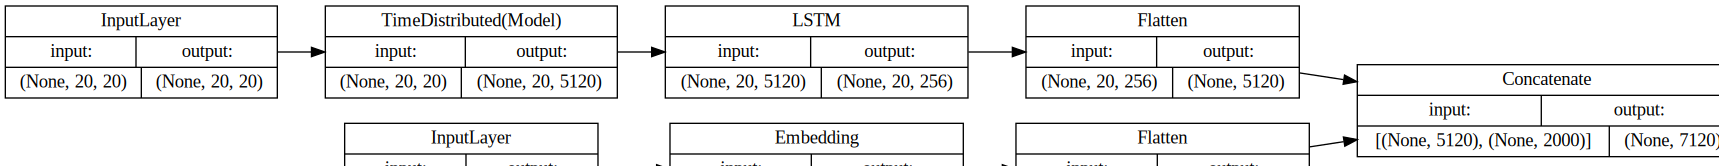

In [45]:
from keras.utils import plot_model
import matplotlib.pyplot as plt
plot_model(model_1,to_file='/content/drive/My Drive/Fake News Challenge/model_1.png',  show_shapes=True,   show_layer_names=False,rankdir='LR')
from IPython.display import SVG
from keras.utils import model_to_dot
SVG(model_to_dot(model_1,rankdir='LR', show_shapes=True, show_layer_names=False,).create(prog='dot', format='svg'))

In [46]:
#Compiling the model
model_1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
#Fitting the model
model_1.fit([x_train, x_heading_train], [y_train], validation_data=([x_val, x_heading_val], [y_val]), epochs=12, batch_size=100)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 39978 samples, validate on 9994 samples
Epoch 1/12
39978/39978 [==============================] - 55s 1ms/step - loss: 0.6845 - acc: 0.7744 - val_loss: 0.3981 - val_acc: 0.8477
Epoch 2/12
39978/39978 [==============================] - 53s 1ms/step - loss: 0.2863 - acc: 0.8912 - val_loss: 0.2501 - val_acc: 0.9037
Epoch 3/12
39978/39978 [==============================] - 54s 1ms/step - loss: 0.1650 - acc: 0.9379 - val_loss: 0.2097 - val_acc: 0.9272
Epoch 4/12
39978/39978 [==============================] - 54s 1ms/step - loss: 0.1002 - acc: 0.9633 - val_loss: 0.1688 - val_acc: 0.9467
Epoch 5/12
39978/39978 [==============================] - 54s 1ms/step - loss: 0.0669 - acc: 0.9761 - val_loss: 0.1733 - val_acc: 0.9449
Epoch 6/12
39978/39978 [==============================] - 54s 1ms/step - loss: 0.0450 - acc: 0.9843 - val_loss: 0.1398 - val_acc: 0.9583
Epoch 7/12
39978/39978 [=======

In [47]:
#Validating the model on val set
score_1 = model_1.evaluate([x_val,x_heading_val], [y_val])
print('Test loss:', score_1[0])
print('Test accuracy:', score_1[1])

9994/9994 [==============================] - 8s 816us/step
Test loss: 0.16210393071512452
Test accuracy: 0.9659795877287954


In [48]:
#Storing the accuracy results for each model in a dataframe for final comparison
results = pd.DataFrame({'Method':['LSTM'], 'accuracy': score_1[1]},index={'1'})
results = results[['Method', 'accuracy']]
results

,Method,accuracy
1,LSTM,0.96598


### Model 2- GRU Model

In [0]:
#Adding the input Layer for article
a_Input_layer_2 = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
#Adding Embedding Layer
a_embedding_layer_2 = Embedding(output_dim=Embed_dim, input_dim=vocab_size, input_length=(MAX_SENT_LENGTH,), weights=[embedding_matrix])(a_Input_layer_2)
#Adding LSTM Layer
a_GRU_layer_2 = (GRU(256, return_sequences=True))(a_embedding_layer_2)
#Adding Dropout Layer
a_dropout_layer_2 = (Dropout(0.2))(a_GRU_layer_2)
#Adding Dense Layer
a_dense_layer_2 = (Dense(units = 256, activation = 'relu'))(a_dropout_layer_2)
#Adding Dropout Layer
a_dropout_layer_22 = (Dropout(0.2))(a_dense_layer_2)
#Adding Flatten Layer
a_flatten_layer_2 = Flatten()(a_dropout_layer_22)
#Encoding the Model 1
Encoder_2 = Model(a_Input_layer_2,a_flatten_layer_2)

#Adding input Layer
a_Input_layer_22 = Input(shape=(MAX_SENTS,MAX_SENT_LENGTH), dtype='int32')
#Adding TimeDistributed Layer
article_encoder_2 = TimeDistributed(Encoder_2)(a_Input_layer_22)
#Adding LSTM layer
a_GRU_layer_22 = GRU(256,return_sequences=True)(article_encoder_2)
#Adding Dropout Layer
a_dropout_layer_222 = (Dropout(0.2))(a_GRU_layer_22)
#Adding Flatten Layer
a_flatten_layer_22 = Flatten()(a_dropout_layer_222)

#Adding input Layer for heading
h_input_layer_2 = Input(shape=(MAX_SENTS_HEADING, MAX_SENT_LENGTH,), dtype='int32')
#Adding Embedding Layer
h_embedded_layer_2 = Embedding(output_dim=Embed_dim, input_dim=vocab_size,  input_length=(MAX_SENTS_HEADING, MAX_SENT_LENGTH,), weights=[embedding_matrix])(h_input_layer_2)
#Adding Dense Layer
h_dense_layer_2 = Dense(100, activation='relu')(h_embedded_layer_2)
#Adding Flatten Layer
h_flatten_layer_2 = Flatten()(h_dense_layer_2)

#Concatenating the two layer
output_2 = concatenate([a_flatten_layer_22, h_flatten_layer_2], name='concatenate_heading')
#Adding the Dense Layer
f_dense_layer_2 = Dense(100, activation='relu')(output_2)
#Adding the Dense Layer
final_output_2 = Dense(4, activation='softmax')(f_dense_layer_2)

#Model Building
model_2 = Model([a_Input_layer_22, h_input_layer_2],[final_output_2])

In [50]:
model_2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 20, 20)       0                                            
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 20, 5120)     3127368     input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1, 20)        0                                            
__________________________________________________________________________________________________
gru_2 (GRU)                     (None, 20, 256)      4129536     time_distributed_2[0][0]         
____________________________________________________________________________________________

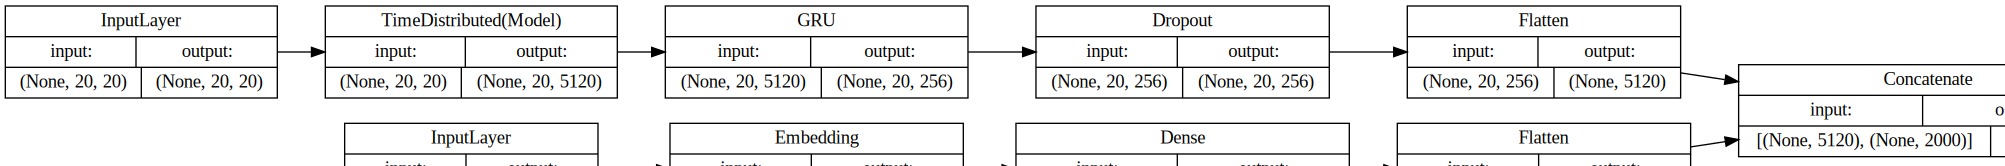

In [51]:
from keras.utils import plot_model
import matplotlib.pyplot as plt
plot_model(model_2,to_file='/content/drive/My Drive/Fake News Challenge/model_2.png',  show_shapes=True,   show_layer_names=False,rankdir='LR')
from IPython.display import SVG
from keras.utils import model_to_dot
SVG(model_to_dot(model_2,rankdir='LR', show_shapes=True, show_layer_names=False,).create(prog='dot', format='svg'))

In [52]:
#Compiling the model
model_2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
#Fitting the model
model_2.fit([x_train, x_heading_train], [y_train], validation_data=([x_val, x_heading_val], [y_val]), epochs=12, batch_size=100)

Train on 39978 samples, validate on 9994 samples
Epoch 1/12
39978/39978 [==============================] - 48s 1ms/step - loss: 0.7115 - acc: 0.7639 - val_loss: 0.4447 - val_acc: 0.8307
Epoch 2/12
39978/39978 [==============================] - 46s 1ms/step - loss: 0.3605 - acc: 0.8633 - val_loss: 0.3047 - val_acc: 0.8841
Epoch 3/12
39978/39978 [==============================] - 46s 1ms/step - loss: 0.2412 - acc: 0.9066 - val_loss: 0.2557 - val_acc: 0.9049
Epoch 4/12
39978/39978 [==============================] - 46s 1ms/step - loss: 0.1718 - acc: 0.9363 - val_loss: 0.2242 - val_acc: 0.9225
Epoch 5/12
39978/39978 [==============================] - 46s 1ms/step - loss: 0.1301 - acc: 0.9501 - val_loss: 0.1988 - val_acc: 0.9312
Epoch 6/12
39978/39978 [==============================] - 46s 1ms/step - loss: 0.0992 - acc: 0.9637 - val_loss: 0.1946 - val_acc: 0.9363
Epoch 7/12
39978/39978 [==============================] - 45s 1ms/step - loss: 0.0792 - acc: 0.9714 - val_loss: 0.3018 - val_acc:

In [53]:
#Validating the model on val set
score_2 = model_2.evaluate([x_val,x_heading_val], [y_val])
print('Test loss:', score_2[0])
print('Test accuracy:', score_2[1])

9994/9994 [==============================] - 7s 750us/step
Test loss: 0.21716445239962687
Test accuracy: 0.9517710626137263


In [54]:
#Store the accuracy results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['GRU'], 'accuracy': [score_2[1]]},index={'2'})
results = pd.concat([results, tempResultsDf])
results = results[['Method', 'accuracy']]
results

,Method,accuracy
1,LSTM,0.965980
2,GRU,0.951771


### Model 3- Bidirectional LSTM Model

In [0]:
#Adding the input Layer for article
a_Input_layer_3 = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
#Adding Embedding Layer
a_embedding_layer_3 = Embedding(output_dim=Embed_dim, input_dim=vocab_size, input_length=(MAX_SENT_LENGTH,), weights=[embedding_matrix])(a_Input_layer_3)
#Adding Bidirectional LSTM Layer
a_BLSTM_layer_3 = Bidirectional(LSTM(256, return_sequences=True))(a_embedding_layer_3)
#Adding Flatten Layer
a_flatten_layer_3 = Flatten()(a_BLSTM_layer_3)
#Encoding 
Encoder_3 = Model(a_Input_layer_3,a_flatten_layer_3)

#Adding input Layer
a_Input_layer_33 = Input(shape=(MAX_SENTS,MAX_SENT_LENGTH), dtype='int32')
#Adding TimeDistributed Layer
article_encoder_3 = TimeDistributed(Encoder_3)(a_Input_layer_33)
#Adding Bidirectional LSTM Layer
a_BLSTM_layer_33 = Bidirectional(LSTM(256, return_sequences=True))(article_encoder_3)
#Adding Flatten Layer
a_flatten_layer_33 = Flatten()(a_BLSTM_layer_33)

#Adding input Layer for heading
h_input_layer_3 = Input(shape=(MAX_SENTS_HEADING, MAX_SENT_LENGTH,), dtype='int32')
#Adding Embedding Layer
h_embedded_layer_3 = Embedding(output_dim=Embed_dim, input_dim=vocab_size,  input_length=(MAX_SENTS_HEADING, MAX_SENT_LENGTH,), weights=[embedding_matrix])(h_input_layer_3)
#Adding Flatten Layer
h_flatten_layer_3 = Flatten()(h_embedded_layer_3)

#Concatenating the two model
output_3 = concatenate([a_flatten_layer_33, h_flatten_layer_3], name='concatenate_heading')

#Adding the Dense Layer
f_dense_layer_3 = Dense(100, activation='relu')(output_3)
#Adding the Dense Layer
final_output_3 = Dense(4, activation='softmax')(f_dense_layer_3)

#Model Building
model_3 = Model([a_Input_layer_33, h_input_layer_3], [final_output_3])

In [56]:
model_3.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 20, 20)       0                                            
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 20, 10240)    3518536     input_8[0][0]                    
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 1, 20)        0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 20, 512)      21497856    time_distributed_3[0][0]         
____________________________________________________________________________________________

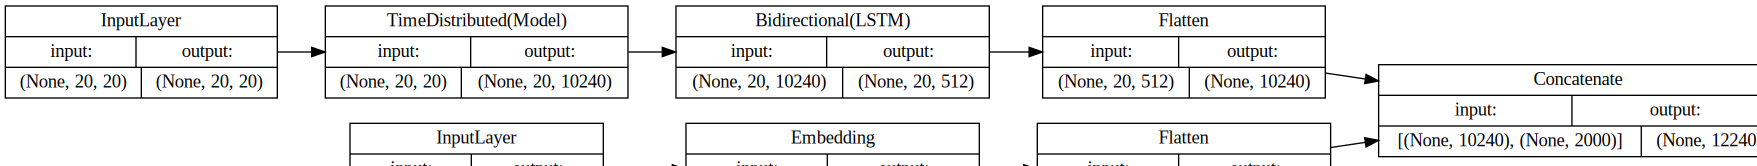

In [57]:
from keras.utils import plot_model
import matplotlib.pyplot as plt
plot_model(model_3,to_file='/content/drive/My Drive/Fake News Challenge/model_3.png',  show_shapes=True,   show_layer_names=False,rankdir='LR')
from IPython.display import SVG
from keras.utils import model_to_dot
SVG(model_to_dot(model_3,rankdir='LR', show_shapes=True, show_layer_names=False,).create(prog='dot', format='svg'))

In [58]:
#Compiling the model
model_3.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
#Fitting the model
model_3.fit([x_train, x_heading_train], [y_train], validation_data=([x_val, x_heading_val], [y_val]), epochs=12, batch_size=100)

Train on 39978 samples, validate on 9994 samples
Epoch 1/12
39978/39978 [==============================] - 132s 3ms/step - loss: 0.7939 - acc: 0.7498 - val_loss: 0.5245 - val_acc: 0.8027
Epoch 2/12
39978/39978 [==============================] - 129s 3ms/step - loss: 0.3996 - acc: 0.8499 - val_loss: 0.3455 - val_acc: 0.8661
Epoch 3/12
39978/39978 [==============================] - 130s 3ms/step - loss: 0.2506 - acc: 0.9055 - val_loss: 0.2761 - val_acc: 0.8958
Epoch 4/12
39978/39978 [==============================] - 129s 3ms/step - loss: 0.1611 - acc: 0.9384 - val_loss: 0.2090 - val_acc: 0.9261
Epoch 5/12
39978/39978 [==============================] - 129s 3ms/step - loss: 0.1066 - acc: 0.9606 - val_loss: 0.1759 - val_acc: 0.9424
Epoch 6/12
39978/39978 [==============================] - 129s 3ms/step - loss: 0.0734 - acc: 0.9744 - val_loss: 0.1643 - val_acc: 0.9468
Epoch 7/12
39978/39978 [==============================] - 128s 3ms/step - loss: 0.0498 - acc: 0.9820 - val_loss: 0.1716 - v

In [59]:
#Validating the model on val set
score_3 = model_3.evaluate([x_val,x_heading_val], [y_val])
print('Test loss:', score_3[0])
print('Test accuracy:', score_3[1])

9994/9994 [==============================] - 17s 2ms/step
Test loss: 0.1794105945880145
Test accuracy: 0.9612767660357796


In [60]:
#Store the accuracy results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['Bidirectional LSTM'], 'accuracy': [score_3[1]]},index={'3'})
results = pd.concat([results, tempResultsDf])
results = results[['Method', 'accuracy']]
results

,Method,accuracy
1,LSTM,0.965980
2,GRU,0.951771
3,Bidirectional LSTM,0.961277


### Model 4- Bidirectional LSTM Attention Model

In [0]:
class AttLayer(Layer):
    def __init__(self, attention_dim):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(AttLayer, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)))
        self.b = K.variable(self.init((self.attention_dim, )))
        self.u = K.variable(self.init((self.attention_dim, 1)))
        self.trainable_weights = [self.W, self.b, self.u]
        super(AttLayer, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return mask

    def call(self, x, mask=None):     
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)
        if mask is not None:
            ait *= K.cast(mask, K.floatx())
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = x * ait
        output = K.sum(weighted_input, axis=1)
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [62]:
#Adding the input Layer for article
a_Input_layer_4 = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
#Adding Embedding Layer
a_embedding_layer_4 = Embedding(output_dim=Embed_dim, input_dim=vocab_size, input_length=(MAX_SENT_LENGTH,), weights=[embedding_matrix])(a_Input_layer_4)
#Adding Bidirectional LSTM Layer
a_BLSTM_layer_4 = Bidirectional(LSTM(256, return_sequences=True))(a_embedding_layer_4)
#Adding Attention layer
a_attention_layer_4 = AttLayer(100)(a_BLSTM_layer_4)
#Encoding 
Encoder_4 = Model(a_Input_layer_4,a_attention_layer_4)

#Adding input Layer
a_Input_layer_44 = Input(shape=(MAX_SENTS,MAX_SENT_LENGTH), dtype='int32')
#Adding TimeDistributed Layer
article_encoder_4 = TimeDistributed(Encoder_4)(a_Input_layer_44)
#Adding Bidirectional LSTM Layer
a_BLSTM_layer_44 = Bidirectional(LSTM(256, return_sequences=True))(article_encoder_4)
#Adding Attention layer
a_attention_layer_44 = AttLayer(100)(a_BLSTM_layer_44)


#Adding input Layer for heading
h_input_layer_4 = Input(shape=(MAX_SENTS_HEADING, MAX_SENT_LENGTH,), dtype='int32')
#Adding Embedding Layer
h_embedded_layer_4 = Embedding(output_dim=Embed_dim, input_dim=vocab_size,  input_length=(MAX_SENTS_HEADING, MAX_SENT_LENGTH,), weights=[embedding_matrix])(h_input_layer_4)
#Adding Flatten Layer
h_flatten_layer_4 = Flatten()(h_embedded_layer_4)

#Concatenating the two model
output_4 = concatenate([a_attention_layer_44, h_flatten_layer_4], name='concatenate_heading')

#Adding the Dense Layer
f_dense_layer_4 = Dense(100, activation='relu')(output_4)
#Adding the Dense Layer
final_output_4 = Dense(4, activation='softmax')(f_dense_layer_4)

#Model Building
model_4 = Model([a_Input_layer_44, h_input_layer_4], [final_output_4])

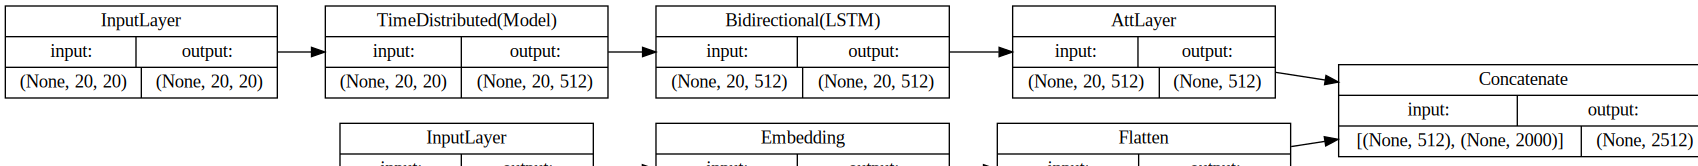

In [63]:
from keras.utils import plot_model
import matplotlib.pyplot as plt
plot_model(model_4,to_file='/content/drive/My Drive/Fake News Challenge/model_4.png',  show_shapes=True,   show_layer_names=False,rankdir='LR')
from IPython.display import SVG
from keras.utils import model_to_dot
SVG(model_to_dot(model_4,rankdir='LR', show_shapes=True, show_layer_names=False,).create(prog='dot', format='svg'))

In [64]:
model_4.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 20, 20)       0                                            
__________________________________________________________________________________________________
time_distributed_4 (TimeDistrib (None, 20, 512)      3569936     input_11[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 1, 20)        0                                            
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 20, 512)      1574912     time_distributed_4[0][0]         
____________________________________________________________________________________________

## Fit the model and report the accuracy score for the model with attention layer (Optional)

In [65]:
#Compiling the model
model_4.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
#Fitting the model
model_4.fit([x_train, x_heading_train], [y_train], validation_data=([x_val, x_heading_val], [y_val]), epochs=12, batch_size=100)

Train on 39978 samples, validate on 9994 samples
Epoch 1/12
39978/39978 [==============================] - 91s 2ms/step - loss: 0.6314 - acc: 0.7612 - val_loss: 0.4926 - val_acc: 0.8059
Epoch 2/12
39978/39978 [==============================] - 87s 2ms/step - loss: 0.3720 - acc: 0.8538 - val_loss: 0.3225 - val_acc: 0.8776
Epoch 3/12
39978/39978 [==============================] - 87s 2ms/step - loss: 0.2267 - acc: 0.9138 - val_loss: 0.2545 - val_acc: 0.9080
Epoch 4/12
39978/39978 [==============================] - 87s 2ms/step - loss: 0.1423 - acc: 0.9478 - val_loss: 0.1950 - val_acc: 0.9324
Epoch 5/12
39978/39978 [==============================] - 86s 2ms/step - loss: 0.0978 - acc: 0.9650 - val_loss: 0.1574 - val_acc: 0.9496
Epoch 6/12
39978/39978 [==============================] - 86s 2ms/step - loss: 0.0699 - acc: 0.9761 - val_loss: 0.1389 - val_acc: 0.9585
Epoch 7/12
39978/39978 [==============================] - 87s 2ms/step - loss: 0.0529 - acc: 0.9818 - val_loss: 0.1467 - val_acc:

In [66]:
#Validating the model on val set
score_4 = model_4.evaluate([x_val,x_heading_val], [y_val])
print('Test loss:', score_4[0])
print('Test accuracy:', score_4[1])

9994/9994 [==============================] - 17s 2ms/step
Test loss: 0.16016517683106207
Test accuracy: 0.9650790474284571


In [67]:
#Store the accuracy results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['Bidirectional LSTM Attention'], 'accuracy': [score_4[1]]},index={'4'})
results = pd.concat([results, tempResultsDf])
results = results[['Method', 'accuracy']]
results

,Method,accuracy
1,LSTM,0.965980
2,GRU,0.951771
3,Bidirectional LSTM,0.961277
4,Bidirectional LSTM Attention,0.965079
